# CHALLENGE PROBLEM 1 CODE – Version 2  
2.156 ML & AI for Design Engineering  
Berfin Ataman & Sergio Mutis

-----------------------------------------------------------------------------------


# CP Instructions

In this challenge problem, the task is to design **2D planar linkage mechanisms** that can trace six given target curves (the “egg” paths). The optimization must balance **accuracy** (distance to target curve) and **efficiency** (total material used), while respecting complexity constraints.

### Constraints
Your solutions must satisfy all three of the following:
1. **Distance Constraint**: Mechanism’s traced curve must be within **0.75** distance of the target curve.  
2. **Material Constraint**: Total linkage length must be **≤ 10.0**.  
3. **Complexity Constraint**: Mechanisms may have at most **20 joints**.  

Mechanisms that violate these constraints will be discarded and will not count toward the score.

### Objective & Scoring
- Each mechanism is evaluated on **two objectives**:  
  - Distance to target curve (minimize).  
  - Material usage (minimize).  
- Performance is measured using the **hypervolume (HV)** indicator with reference point **(0.75, 10.0)**.  
- For each target curve, you may submit up to **1000 mechanisms**.  
- The **average hypervolume across all six target curves** determines your final score.

### Optimization Methods
You are expected to use and possibly combine the following strategies:
- **Genetic Algorithms (GA):** Optimize both mechanism structures (edges, connectivity) and joint positions. You may experiment with:
  - Preprocessing or filtering random mechanisms before GA.  
  - Modified mutation and crossover operators.  
  - Mixed-variable GA setups using connectivity matrices.  
- **Gradient-Based Optimization (GD):** Use differentiable tools to optimize joint positions. Consider gradients of both objectives (distance and material).  
- **Hybrid / Iterative Approaches:**  
  - Cycle between GA and GD to refine solutions.  
  - Compare and save improved populations incrementally (keep solutions only if they improve HV).  
  - Explore more efficient mechanism representations to reduce parameter space.

### Deliverables
For each of the six target curves:  
- Generate and submit up to **1000 valid mechanisms**.  
- Ensure mechanisms are evaluated with the provided tools (`Tools`, `DifferentiableTools`).  
- Organize results so that **hypervolumes can be calculated and compared** against baseline solutions.  

Your goal is to maximize the average hypervolume score across all six problems by producing mechanisms that are both accurate and efficient under the given constraints.

----------------------------------------------------------------------------------------

# Method Outline
1. Setup  
2. Initial Population  
3. GA Optimization  
4. GD Refinement  
5. Compare and Save Improved Solutions  

# LOG
- Step 1: Cleaned the advance notebook to be more streamlined (SM)  
- Step 1: Parametriced the curve to run all optimizations by updating the curve (SM)  
- Step 2: Improved Initial Population (SM)  
   - Generate seeds at fixed size N=7 to match GA encoding  
   - Filter out invalid mechanisms (distance > 0.75, material > 10, >20 joints)  
   - Early-stop once enough feasible seeds collected  
   - Apply ε-deduplication + non-dominated filtering + max–min spread to select diverse seeds  
   - Added progress bars and diagnostics for visibility  
- Step 5: Added a 'Compare and Save Improved Solutions' (SM)  
   - Compares the hypervolume of the new set of solutions to the previous hypervolume, then save only if the new solutions are better for that curve. (incremental improvement)  

# TO-DO
- Step 2: GA Multi-N generation  
- Step 4: GD make GD a function of both material and distance  
- Step 4: GD add adaptive decay  
- Step 5: Compare & Save update → union old + new, Pareto-prune, recompute HV, and save  
   - Ensures HV never decreases; if capped at 1000, apply HV-aware pruning with fallback  
- General: Batch curve optimization (run on multiple indexes at once)  
- General: Batch run seed (run GA+GD multiple times with different seeds → union results → prune to top 1000 HV)  
- General: Parameterize optimization hyperparameters (pop_size, n_gen, per_size, target_valid, eps, GD step size, etc.) for easier tuning




# Official Hints:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

___________________________________________________________________________________________

# 1. SETUP!

Target Optimization Curve

In [ ]:
# --- Configurable target curve ---
curve_index = 1   # 0-based index: 0 = Problem 1, 1 = Problem 2, ..., 5 = Problem 6
NODES=7

a. Environment Setup

In [34]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
# np.random.seed(0)
# random.seed(0)

import matplotlib as mpl
plt.style.use('default')  # reset any dark style
mpl.rcParams.update({
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
})

In [35]:
# --- switches to control heavy steps ---
RUN_GD   = False   # set True only when you actually want to run GD
GD_TOPK  = 8       # refine only the top-K GA designs
GD_STEPS = 150     # small number; increase later if needed


b. Load Tarject Cruves

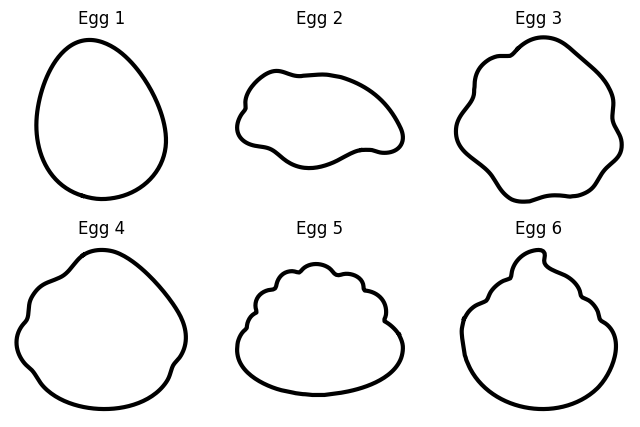

In [36]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


c. Optimization Imports

In [37]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

d. Problem Definition (Tools + Pymoo class)

In [38]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = NODES):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


# 2. Initial Population

a. Imports and helpers

In [39]:
# === Section 2 — Cell 1: Seeding utilities (single-size, early-stop, ε-dedup) ===
from LINKS.Optimization import MechanismRandomizer, Tools
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from tqdm.auto import tqdm
import numpy as np
from time import perf_counter
from collections import defaultdict

# Use the same device everywhere
TOOLS = Tools(device='cpu')
TOOLS.compile()

def epsilon_dedup(F, eps=(5e-4, 5e-3)):
    """
    Keep at most one point per epsilon-box in (distance, material) objective space.
    eps is (eps_distance, eps_material).
    """
    if len(F) == 0:
        return np.array([], dtype=int)
    keys = (np.floor(F[:,0]/eps[0]).astype(int), np.floor(F[:,1]/eps[1]).astype(int))
    seen, keep = set(), []
    for i, key in enumerate(zip(*keys)):
        if key not in seen:
            seen.add(key)
            keep.append(i)
    return np.array(keep, dtype=int)

def generate_pool_single_size(n=7, per_size=200, desc="Sampling mechanisms"):
    """
    Randomize mechanisms at exactly size n (to match GA encoding N=n).
    """
    t0 = perf_counter()
    pool = []
    randomizer = MechanismRandomizer(min_size=n, max_size=n, device='cpu')
    for _ in tqdm(range(per_size), desc=f"{desc} n={n}", leave=False):
        pool.append(randomizer(n=n))
    print(f"[seed] sampled {len(pool)} candidates at n={n} in {perf_counter()-t0:.1f}s")
    return pool

def evaluate_mechs(mechs, target_curve, problem, diag_every=200,
                   distance_max=0.75, material_max=10.0, max_joints=20,
                   target_valid=120):
    """
    Evaluate pool, keep only constraint-satisfying candidates, show running diagnostics.
    Early-stops once target_valid feasible candidates are collected.
    """
    t0 = perf_counter()
    X_dicts, F_list, valid = [], [], []
    size_hist = defaultdict(int)
    best = {"distance": np.inf, "material": np.inf}
    ref = np.array([distance_max, material_max])

    pbar = tqdm(total=len(mechs), desc="[eval] checking constraints", leave=False)
    for i, mech in enumerate(mechs, 1):
        x0, edges, fixed_joints, motor = mech['x0'], mech['edges'], mech['fixed_joints'], mech['motor']
        # default: last node is target
        distance, material = TOOLS(x0, edges, fixed_joints, motor, target_curve, target_idx=x0.shape[0]-1)

        best["distance"] = min(best["distance"], distance)
        best["material"] = min(best["material"], material)

        if (distance <= distance_max) and (material <= material_max) and (x0.shape[0] <= max_joints):
            X = problem.convert_mech_to_1D(x0=x0, edges=edges, fixed_joints=fixed_joints,
                                           target_idx=x0.shape[0]-1, motor=motor)
            X_dicts.append(X)
            F_list.append([distance, material])
            valid.append(mech)
            size_hist[x0.shape[0]] += 1

        if (i % diag_every == 0) or (i == len(mechs)):
            acc = len(X_dicts) / i
            pbar.set_postfix({
                "seen": i,
                "valid": len(X_dicts),
                "acc%": f"{100*acc:.1f}",
                "best_d": f"{best['distance']:.3f}",
                "best_m": f"{best['material']:.3f}"
            })
        pbar.update(1)

        # Early stop if we hit target_valid feasible seeds
        if len(X_dicts) >= target_valid:
            break

    pbar.close()

    F = np.array(F_list) if F_list else np.zeros((0,2))
    print(f"[eval] done in {perf_counter()-t0:.1f}s | valid={len(X_dicts)} "
          f"({100*len(X_dicts)/max(1, min(len(mechs), i)):.1f}%)")
    if len(X_dicts):
        print(f"[eval] valid F ranges: distance [{F[:,0].min():.3f}, {F[:,0].max():.3f}] | "
              f"material [{F[:,1].min():.3f}, {F[:,1].max():.3f}] | ref={tuple(ref)}")
        sizes_sorted = sorted(size_hist.items())
        dist_str = ", ".join([f"n={k}:{v}" for k,v in sizes_sorted])
        print(f"[eval] size distribution among valid: {dist_str}")
    return X_dicts, F, valid

def select_diverse_non_dominated(X_dicts, F, k=100, title="[seed selection]"):
    """
    1) Non-dominated filter, 2) Max-min spread selection to k.
    (Assumes ε-dedup already applied if desired.)
    """
    if len(X_dicts) == 0:
        print(f"{title} no candidates to select."); return []
    nds = NonDominatedSorting().do(F, only_non_dominated_front=True)
    X_nd, F_nd = [X_dicts[i] for i in nds], F[nds]
    print(f"{title} non-dominated front size: {len(X_nd)}")

    if len(X_nd) <= k:
        print(f"{title} selected all {len(X_nd)} (<= k={k})")
        return X_nd

    # Greedy max-min spread
    chosen = [int(np.argmin(F_nd.sum(axis=1)))]
    dist = np.linalg.norm(F_nd - F_nd[chosen[0]], axis=1)
    for _ in tqdm(range(k-1), desc=f"{title} max-min pick", leave=False):
        next_i = int(np.argmax(dist))
        chosen.append(next_i)
        dist = np.minimum(dist, np.linalg.norm(F_nd - F_nd[next_i], axis=1))
    print(f"{title} selected k={k} diverse seeds")
    return [X_nd[i] for i in chosen]



b. Generate and evaluate pool

In [40]:
# === Section 2 — Cell 2: Build initial pool and filter (single-size matching GA N) ===
# IMPORTANT: Make sure GA encoding uses the same N below.
GA_N = NODES # must match the N used when you instantiate `problem` in Section 3

# Reuse your existing problem object if already defined earlier:
try:
    problem
except NameError:
    problem = mechanism_synthesis_optimization(target_curves[curve_index], N=GA_N)

# Step 1: generate pool (exactly n=GA_N to avoid padding artifacts)
raw_pool = generate_pool_single_size(n=GA_N, per_size=200)  # tweak per_size if needed

# Step 2: evaluate and filter with early-stop
X_dicts, F, valid_mechs = evaluate_mechs(
    raw_pool,
    target_curve=target_curves[curve_index],
    problem=problem,
    diag_every=200,
    distance_max=0.75,   # you can tighten (e.g., 0.60) to bias better seeds
    material_max=10.0,   # you can tighten (e.g., 9.0) to leave headroom
    max_joints=20,
    target_valid=120     # early-stop once we have enough good seeds
)
# --- Seed safety: ensure initial_population exists ---
from pymoo.core.mixed import MixedVariableSampling

if 'initial_population' not in globals() or len(initial_population) == 0:
    # Try to build some random seeds if filtering found none
    n_fallback =  max(20, globals().get('POP', 60)//3)
    initial_population = MixedVariableSampling().do(problem, n_fallback)
    print(f"[fallback] Built {len(initial_population)} random seeds because initial_population was empty.")
else:
    print(f"[seed] Using {len(initial_population)} seeded designs.")

Sampling mechanisms n=7:   0%|          | 0/200 [00:00<?, ?it/s]

[seed] sampled 200 candidates at n=7 in 3.2s


[eval] checking constraints:   0%|          | 0/200 [00:00<?, ?it/s]

[eval] done in 0.2s | valid=4 (2.0%)
[eval] valid F ranges: distance [0.310, 0.456] | material [6.058, 9.951] | ref=(np.float64(0.75), np.float64(10.0))
[eval] size distribution among valid: n=7:4
[seed] Using 3 seeded designs.


c. Select initial population

In [41]:
# === Section 2 — Cell 3: ε-dedup + pick diverse non-dominated seeds ===
# Optional ε-dedup before selecting spread to reduce near-duplicates
if len(F) > 0:
    dd_idx = epsilon_dedup(F, eps=(5e-4, 5e-3))  # tweak eps if too aggressive
    X_dd = [X_dicts[i] for i in dd_idx]
    F_dd = F[dd_idx]
else:
    X_dd, F_dd = [], F

initial_population = select_diverse_non_dominated(X_dd, F_dd, k=100, title="[seed selection]")
print(f"[seed] → init pop size: {len(initial_population)}")



[seed selection] non-dominated front size: 2
[seed selection] selected all 2 (<= k=100)
[seed] → init pop size: 2


# 3. GA Optimization

b. GA Optimization Setup

In [42]:
# === 3.b — GA sampling helper (robust to empty seeds) ===
import numpy as np
from pymoo.core.sampling import Sampling
from pymoo.core.mixed import MixedVariableSampling

# If Section 2 gave us seeds, use them; else fall back to random mixed sampling
seeded = initial_population if ('initial_population' in globals() and len(initial_population) > 0) else []

class sample_from_seeds(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        n = int(n_samples)
        if len(seeded) > 0:
            print(f"[3.b] Using seeded sampling; n_seeds={len(seeded)}")
            return np.array([seeded[i % len(seeded)] for i in range(n)], dtype=object)
        else:
            print("[3.b] Using random sampling; n_seeds=0")
            return MixedVariableSampling().do(problem, n)

# Optional: quick seed quality print (only if we actually have seeds)
if len(seeded) > 0:
    F_seed = problem.evaluate(np.array(seeded, dtype=object))[0]
    print(f"[seed] count={len(seeded)} | "
          f"dist[min/mean]={F_seed[:,0].min():.3f}/{F_seed[:,0].mean():.3f} | "
          f"mat[min/mean]={F_seed[:,1].min():.3f}/{F_seed[:,1].mean():.3f}")


[seed] count=2 | dist[min/mean]=0.310/0.373 | mat[min/mean]=6.058/7.151


In [43]:
# === 3 — GA config ===
POP      = 150
N_GEN    = 150
MUT_PROB = 0.90

# Only needed later for 3.e multi-seed restarts:
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 11, 13]

print("POP:", POP, "N_GEN:", N_GEN, "MUT_PROB:", MUT_PROB, "SEEDS:", SEEDS)


POP: 150 N_GEN: 150 MUT_PROB: 0.9 SEEDS: [0, 1, 2, 3, 4, 5, 6, 7, 11, 13]


c. GA Optimization

In [44]:
# === 3.c — GA run (mixed-variable safe) ===
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.mixed import MixedVariableMating, MixedVariableDuplicateElimination
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

deduper = MixedVariableDuplicateElimination()

algorithm = NSGA2(
    pop_size=100,
    sampling=sample_from_seeds(),
    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
    mutation=PolynomialMutation(prob=MUT_PROB),
    eliminate_duplicates=False                                 
)
# Optional sanity check: these must NOT be bool
print("[debug] mating deduper:", type(algorithm.mating.eliminate_duplicates))
print("[debug] algo deduper:  ", type(algorithm.eliminate_duplicates))

results = minimize(
    problem,
    algorithm,
    ('n_gen', N_GEN),
    verbose=True,
    save_history=True,
    seed=int(np.random.randint(1_000_000_000))     # fresh run-to-run seed
)





[debug] mating deduper: <class 'pymoo.core.mixed.MixedVariableDuplicateElimination'>
[debug] algo deduper:   <class 'pymoo.core.duplicate.NoDuplicateElimination'>
[3.b] Using seeded sampling; n_seeds=2
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |    100 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0069694319 |         ideal
     3 |      300 |      4 |  0.000000E+00 |  0.000000E+00 |  0.1546831154 |         ideal
     4 |      400 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0049418679 |         ideal
     5 |      500 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0409352994 |         ideal
     6 |      600 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0396673604 |         ideal
     7 |      700 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0073063475 |         ideal
     8 |      800 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000

d. Hypervolume Check

Hyper Volume ~ 3.317853


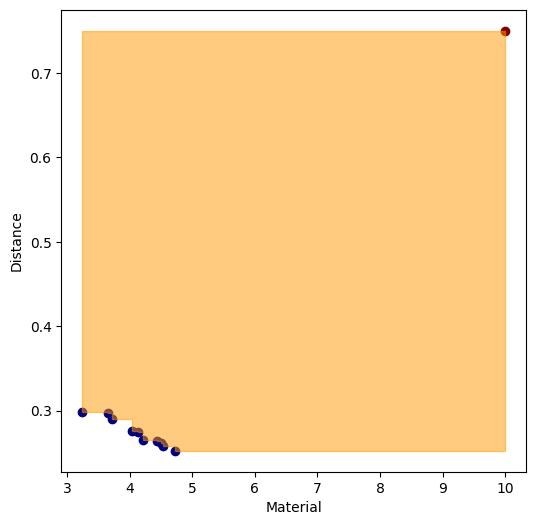

In [45]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

3E: GA multi-seed restarts (union + HV)

[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 0: 17 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 1: 12 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 2: 15 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 3: 12 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 4: 15 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 5: 12 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 6: 17 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 7: 11 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 11: 13 pts
[3.b] Using seeded sampling; n_seeds=2
[3.e] seed 13: 23 pts


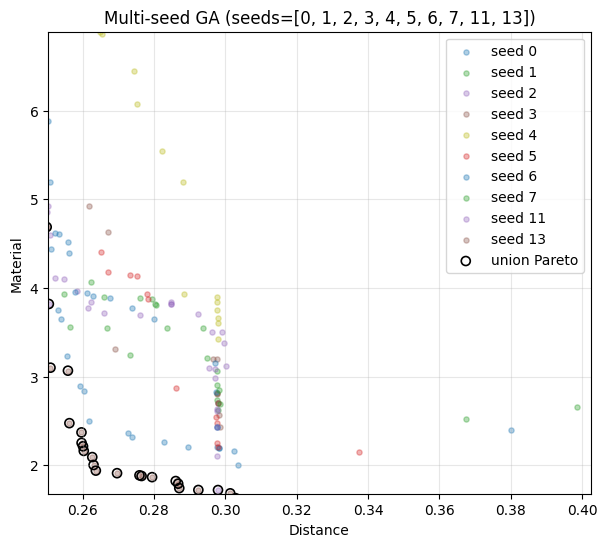

Union HV @ ref(0.75,10.0): 4.211585
[multi-seed] union Pareto size: 25


In [46]:
# === 3.e — GA Multi-Seed Restarts (union + Pareto + HV) — FIXED ===
import numpy as np, matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.mixed import MixedVariableMating, MixedVariableDuplicateElimination
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV

# Config (use your existing POP/N_GEN/MUT_PROB; tweak seeds if you like)
POP   = globals().get("POP", 150)
N_GEN = globals().get("N_GEN", 150)
SEEDS = globals().get("SEEDS", [0,1,2,3,4,5,6,7,11,13])
MUT_PROB = globals().get("MUT_PROB", 0.90)

# Reuse your 3.b helper; it falls back to random if no seeds are available
assert 'sample_from_seeds' in globals(), "sample_from_seeds() must be defined in 3.b"

# --- Build an algorithm with the safe dedup config ---
def make_algo():
    return NSGA2(
        pop_size=POP,
        sampling=sample_from_seeds(),                                # seeds if present, else random
        mating=MixedVariableMating(
            eliminate_duplicates=MixedVariableDuplicateElimination() # ✅ dedup at mating (compatible with mixed dict vars)
        ),
        mutation=PolynomialMutation(prob=MUT_PROB),
        eliminate_duplicates=False                                   # ✅ turn OFF algorithm-level dedup (prevents 'Individual.items()' crash)
    )

# Helpers to robustly extract final F/X (covers different pymoo versions)
def extract_final_F(res):
    F = getattr(res, "F", None)
    if isinstance(F, np.ndarray) and F.ndim == 2 and len(F):
        return F
    algo = getattr(res, "algorithm", None)
    if algo is not None and hasattr(algo, "pop"):
        Fp = algo.pop.get("F")
        if Fp is not None and len(Fp): return np.asarray(Fp)
    H = getattr(res, "history", None)
    if H:
        e = H[-1]
        try:
            Fh = e.opt.get("F") or e.pop.get("F")
            if Fh is not None and len(Fh): return np.asarray(Fh)
        except Exception:
            pass
    return None

def extract_final_X(res):
    X = getattr(res, "X", None)
    if isinstance(X, np.ndarray) and len(X):
        return X
    algo = getattr(res, "algorithm", None)
    if algo is not None and hasattr(algo, "pop"):
        Xp = algo.pop.get("X")
        if Xp is not None and len(Xp): return np.asarray(Xp, dtype=object)
    H = getattr(res, "history", None)
    if H:
        e = H[-1]
        try:
            Xh = e.opt.get("X") or e.pop.get("X")
            if Xh is not None and len(Xh): return np.asarray(Xh, dtype=object)
        except Exception:
            pass
    return None

def pareto_mask(F):
    F = np.asarray(F, float)
    n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not np.isfinite(F[i]).all():
            keep[i] = False; continue
        for j in range(n):
            if i == j: continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False; break
    return keep

# --- Run all seeds (no hard failure if initial_population is empty) ---
runs = []
for sd in SEEDS:
    try:
        algo = make_algo()
        res  = minimize(problem, algo, ('n_gen', N_GEN), verbose=False, seed=sd, save_history=True)
        Ffin = extract_final_F(res)
        Xfin = extract_final_X(res)
        if Ffin is None or Xfin is None:
            Ffin = np.empty((0,2)); Xfin = np.empty((0,), dtype=object)
        m = np.isfinite(Ffin).all(axis=1)
        Ffin, Xfin = Ffin[m], Xfin[m]
        runs.append((sd, Ffin, Xfin))
        print(f"[3.e] seed {sd}: {len(Ffin)} pts")
    except Exception as e:
        print(f"[3.e] seed {sd} failed: {e}")
        runs.append((sd, np.empty((0,2)), np.empty((0,), dtype=object)))

# --- Combine & Pareto-prune union ---
allF = np.vstack([F for _,F,_ in runs]) if any(len(F) for _,F,_ in runs) else np.empty((0,2))
allX = np.concatenate([X for _,_,X in runs]) if any(len(X) for _,_,X in runs) else np.empty((0,), dtype=object)

if len(allF):
    mask = pareto_mask(allF)
    UNION_F = allF[mask]
    UNION_X = allX[mask]
else:
    UNION_F = np.empty((0,2)); UNION_X = np.empty((0,), dtype=object)

# --- Plot per-seed + union front ---
plt.figure(figsize=(7,6))
colors = ['tab:blue','tab:green','tab:purple','tab:brown','tab:olive','tab:red']
for k,(sd,F,X) in enumerate(runs):
    if len(F):
        plt.scatter(F[:,0], F[:,1], s=14, alpha=0.35, color=colors[k % len(colors)], label=f"seed {sd}")
if len(UNION_F):
    plt.scatter(UNION_F[:,0], UNION_F[:,1], s=42, edgecolors='k', facecolors='none', linewidths=1.2, label="union Pareto")
    lo = np.quantile(allF, 0.02, axis=0); hi = np.quantile(allF, 0.98, axis=0)
    plt.xlim(lo[0], hi[0]); plt.ylim(lo[1], hi[1])
plt.xlabel("Distance"); plt.ylabel("Material"); plt.title(f"Multi-seed GA (seeds={SEEDS})")
plt.grid(True, alpha=0.3); 
if len(UNION_F): plt.legend()
plt.show()

# --- HV at official reference point ---
if len(UNION_F):
    hv = HV(ref_point=[0.75, 10.0])(UNION_F)
    print(f"Union HV @ ref(0.75,10.0): {hv:.6f}")
else:
    print("No finite points found across seeds.")

# --- Convert union X (dict/object) to mechanism dicts for Step 5 ---
def to_mech_list_from_X(problem, X_array):
    out = []
    for x in X_array:
        x0, e, fj, m, t = problem.convert_1D_to_mech(x)
        out.append({"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t})
    return out

UNION_MECHS = to_mech_list_from_X(problem, UNION_X) if len(UNION_X) else []
print(f"[multi-seed] union Pareto size: {len(UNION_MECHS)}")


3E sanity check
Compare union HV to single-run HV: higher = multi-seed helped.
Look at feasible-only HV: this is the one that matters for scoring.
Check per-seed contributions: ideally, multiple seeds contribute ≥1 union point. 

In [47]:
# === Multi-seed QA / sanity checks (put under 3.e) ===
import numpy as np
from pymoo.indicators.hv import HV

REF = np.array([0.75, 10.0])
MAX_HV = float(np.prod(REF))  # 7.5

def pareto_mask(F):
    F = np.asarray(F, float)
    n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        if not np.isfinite(F[i]).all():
            keep[i] = False; continue
        for j in range(n):
            if i == j: continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False; break
    return keep

# Rebuild ALL from the 'runs' you created in 3.e
allF, sizes = [], []
for sd, F, X in runs:
    allF.append(F)
    sizes.append(len(F))
ALL = np.vstack(allF) if any(sizes) else np.empty((0,2))

mask = pareto_mask(ALL) if len(ALL) else np.array([], dtype=bool)
FRONT = ALL[mask] if len(ALL) else np.empty((0,2))

# Union HV and fraction of theoretical max
hv_union = HV(ref_point=REF)(FRONT) if len(FRONT) else 0.0
print(f"Union HV @ ref {REF.tolist()}: {hv_union:.6f}  ({hv_union/MAX_HV:.1%} of max {MAX_HV:.3f})")
print(f"Union Pareto size: {len(FRONT)}")

# Feasible-only HV (challenge cares about feasible)
if len(FRONT):
    feas = (FRONT[:,0] <= REF[0]) & (FRONT[:,1] <= REF[1])
    FRONT_feas = FRONT[feas]
    hv_feas = HV(ref_point=REF)(FRONT_feas) if len(FRONT_feas) else 0.0
    print(f"Feasible-only HV: {hv_feas:.6f}  ({(hv_feas/MAX_HV if MAX_HV>0 else 0):.1%})")
    print(f"Feasible on union front: {len(FRONT_feas)}/{len(FRONT)}")
else:
    print("No union front points to evaluate feasibility.")

# Per-seed feasible HV and contributions to union front
offsets = np.cumsum([0] + sizes)  # index ranges inside ALL for each seed
contrib = np.zeros(len(runs), dtype=int)
if len(ALL):
    idxs = np.where(mask)[0]
    for idx in idxs:
        k = np.searchsorted(offsets, idx, side='right') - 1
        contrib[k] += 1

print("\nPer-seed stats:")
for i, (sd, F, X) in enumerate(runs):
    if len(F):
        Ff = F[(F[:,0] <= REF[0]) & (F[:,1] <= REF[1])]
        hv_s = HV(ref_point=REF)(Ff) if len(Ff) else 0.0
        print(f"  Seed {sd}: {len(Ff):3d}/{len(F):3d} feasible, HV={hv_s:.6f}, contributes {contrib[i]} union pts")
    else:
        print(f"  Seed {sd}: no points")


Union HV @ ref [0.75, 10.0]: 4.211585  (56.2% of max 7.500)
Union Pareto size: 25
Feasible-only HV: 4.211585  (56.2%)
Feasible on union front: 25/25

Per-seed stats:
  Seed 0:  17/ 17 feasible, HV=3.962559, contributes 0 union pts
  Seed 1:  12/ 12 feasible, HV=3.598114, contributes 0 union pts
  Seed 2:  15/ 15 feasible, HV=3.462880, contributes 0 union pts
  Seed 3:  12/ 12 feasible, HV=3.649920, contributes 0 union pts
  Seed 4:  15/ 15 feasible, HV=3.126814, contributes 0 union pts
  Seed 5:  12/ 12 feasible, HV=3.754802, contributes 0 union pts
  Seed 6:  17/ 17 feasible, HV=3.725057, contributes 0 union pts
  Seed 7:  11/ 11 feasible, HV=3.603473, contributes 0 union pts
  Seed 11:  13/ 13 feasible, HV=4.044717, contributes 2 union pts
  Seed 13:  23/ 23 feasible, HV=4.211180, contributes 23 union pts


# 4. GD Optimization

a. GD Setup

In [48]:
# === 4. GD Refinement (lite & safe) ===
# Replaces BOTH: (a) distance-only loop and (b) material-aware loop.
# Uses RUN_GD / GD_TOPK / GD_STEPS switches defined at the top.

from pymoo.indicators.hv import HV
from tqdm.auto import trange
import numpy as np

if RUN_GD and (not results.X is None):
    # 1) Build a small batch from GA results (top-K)
    X_batch = results.X if not isinstance(results.X, dict) else [results.X]
    X_objs  = results.F if hasattr(results, "F") else None

    # Rank by (distance + 0.1*material) if F is available; else just take first K
    if X_objs is not None and len(X_objs) == len(X_batch):
        order = np.argsort(X_objs[:,0] + 0.1*X_objs[:,1])[:GD_TOPK]
        X_pick = [X_batch[i] for i in order]
    else:
        X_pick = X_batch[:GD_TOPK]

    # 2) Convert to mechanism representation
    x0s, edges, fixed_joints, motors, target_idxs = [], [], [], [], []
    for sol in (X_pick if isinstance(X_pick, (list, tuple)) else [X_pick]):
        x0, e, fj, m, t = problem.convert_1D_to_mech(sol)
        x0s.append(x0); edges.append(e); fixed_joints.append(fj); motors.append(m); target_idxs.append(t)

    # 3) Warm-up compile (first call can be slow, done once)
    _ = differentiable_optimization_tools(
        x0s, edges, fixed_joints, motors, target_curves[curve_index], target_idxs
    )

    # 4) Small, safe bi-objective refinement with decay + patience
    x_cur = [arr.copy() for arr in x0s]
    step  = 3e-4
    decay = 0.97
    ref   = np.array([0.75, 10.0])
    w_dist, w_mat = 0.7, 0.3
    patience, no_improve = 25, 0

    def batch_HV(Xlist):
        F = []
        for Xi, Ei, Fj, Mi, Ti in zip(Xlist, edges, fixed_joints, motors, target_idxs):
            d, m = TOOLS(Xi, Ei, Fj, Mi, target_curves[curve_index], target_idx=Ti)
            F.append([d, m])
        F = np.asarray(F, float)
        F = F[np.isfinite(F).all(axis=1)]
        return (HV(ref_point=ref)(F) if len(F) else 0.0), F

    hv0, _ = batch_HV(x_cur)

    for it in trange(GD_STEPS, desc="[GD-lite]"):
        d, m, g_d, g_m = differentiable_optimization_tools(
            x_cur, edges, fixed_joints, motors, target_curves[curve_index], target_idxs
        )

        # weighted descent direction (normalize per design)
        dirs = []
        for gd_i, gm_i in zip(g_d, g_m):
            g = w_dist*gd_i + w_mat*(gm_i/10.0)   # scale material gradient


GD lite replacement of material and dstance


In [49]:
from LINKS.Optimization import DifferentiableTools

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[curve_index],
    target_idxs
)

# print(materials, distances)

In [50]:
# === Merge populations (No-GD version): GA batch only ===
# Place this RIGHT AFTER your GD-lite cell and BEFORE Step 5.

assert all(n in globals() for n in ["x0s","edges","fixed_joints","motors","target_idxs"]), \
    "Run the GA→batch setup that builds x0s/edges/fixed_joints/motors/target_idxs first."

combined_x0s          = list(x0s)
combined_edges        = list(edges)
combined_fixed_joints = list(fixed_joints)
combined_motors       = list(motors)
combined_target_idxs  = list(target_idxs)

print(f"[merge/no-GD] combined={len(combined_x0s)} designs (GA only)")

# Sanity check
sizes = {len(combined_x0s), len(combined_edges), len(combined_fixed_joints),
         len(combined_motors), len(combined_target_idxs)}
assert len(sizes) == 1, f"Merged lists misaligned (sizes={sizes})"

[merge/no-GD] combined=10 designs (GA only)


Prep for step 5

In [51]:
# === Step 5 prep: prefer the union Pareto mechs from 3.e ===
try:
    candidate_list = UNION_MECHS
    print(f"[step5-prep] Using UNION_MECHS ({len(candidate_list)}) as candidate_list.")
except NameError:
    print("[step5-prep] UNION_MECHS not found; Step 5 will choose from GA/GD fallbacks.")


[step5-prep] Using UNION_MECHS (25) as candidate_list.


Makes sure we use the improved result from multi seed 

In [52]:
# Use the multi-seed union for saving
candidate_list = UNION_MECHS
print(f"[step5-prep] Using UNION_MECHS ({len(candidate_list)}) as candidate_list.")


[step5-prep] Using UNION_MECHS (25) as candidate_list.


preview the candidate score vs saved

In [53]:
from LINKS.CP import make_empty_submission, evaluate_submission
import numpy as np, os

ci = curve_index + 1  # 1-based for the scorer
assert 'candidate_list' in globals() and len(candidate_list), "candidate_list is empty"

# current saved score
if os.path.exists("my_submission.npy"):
    saved = np.load("my_submission.npy", allow_pickle=True).item()
    saved_list = saved.get(f"Problem {ci}", [])
    saved_score = evaluate_submission({**make_empty_submission(), f"Problem {ci}": saved_list})["Score Breakdown"][f"Problem {ci}"] if saved_list else 0.0
else:
    saved_score = 0.0

# candidate score (union mechs)
cand_score = evaluate_submission({**make_empty_submission(), f"Problem {ci}": candidate_list[:1000]})["Score Breakdown"][f"Problem {ci}"]

print(f"Saved score for Problem {ci}:     {saved_score:.6f}")
print(f"Candidate (union) score for P{ci}: {cand_score:.6f}")
print("Will update:", cand_score > saved_score + 1e-12)

Saved score for Problem 3:     3.125183
Candidate (union) score for P3: 4.211584
Will update: True


# 5. Compare and Save Improved Solutions (per curve)

In [54]:
# === Step 5: Compare & Save Improved Solutions (per curve) ===
# Place this AFTER 3.e (UNION_MECHS) and AFTER 4b (Material-GD) so both are available.

import os, time
import numpy as np
from LINKS.CP import make_empty_submission, evaluate_submission

submission_path = "my_submission.npy"
require_margin  = 1e-12
per_problem_cap = 1000   # cap per problem

# ----- Helpers -----
def load_submission(path=submission_path):
    if os.path.exists(path):
        return np.load(path, allow_pickle=True).item()
    return make_empty_submission()

def save_submission(sub, path=submission_path):
    if os.path.exists(path):
        ts = time.strftime("%Y%m%d-%H%M%S")
        bak = path.replace(".npy", f".{ts}.bak.npy")
        np.save(bak, np.load(path, allow_pickle=True))
        print(f"[backup] {bak}")
    np.save(path, sub)

def cap_list(lst, limit=None):
    if limit is None: limit = per_problem_cap
    return lst[:limit]

def score_only_curve(mech_list, curve_1based):
    tmp = make_empty_submission()
    key = f"Problem {curve_1based}"
    tmp[key] = mech_list
    return evaluate_submission(tmp)["Score Breakdown"][key]

def pareto_mask(F):
    n = len(F)
    keep = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(n):
            if i == j: 
                continue
            if np.all(F[j] <= F[i]) and np.any(F[j] < F[i]):
                keep[i] = False
                break
    return keep

def eval_mech_list(mechs):
    F = []
    for mech in mechs:
        d, mm = TOOLS(mech["x0"], mech["edges"], mech["fixed_joints"], mech["motor"],
                      target_curves[curve_index], target_idx=mech["target_joint"])
        F.append([d, mm])
    return np.asarray(F, float)

# ----- Build pool: GA union ∪ material-GD ∪ fallback combined -----
POOL = []

# GA multi-seed union (preferred)
if 'UNION_MECHS' in globals() and len(UNION_MECHS) > 0:
    POOL += UNION_MECHS

# Material-aware GD batch (if ran)
if 'MAT_x0s' in globals():
    POOL += [
        {"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t}
        for x0, e, fj, m, t in zip(MAT_x0s, edges, fixed_joints, motors, target_idxs)
    ]

# Fallback combined (GA+GD) if nothing else
if len(POOL) == 0 and 'combined_x0s' in globals():
    POOL = [
        {"x0": x0, "edges": e, "fixed_joints": fj, "motor": m, "target_joint": t}
        for x0, e, fj, m, t in zip(combined_x0s, combined_edges, combined_fixed_joints, combined_motors, combined_target_idxs)
    ]

# Feasible filter
F_pool = eval_mech_list(POOL) if len(POOL) else np.empty((0,2))
feas = (F_pool[:,0] <= 0.75) & (F_pool[:,1] <= 10.0)
POOL, F_pool = [POOL[i] for i in np.where(feas)[0]], F_pool[feas]

# Light ε-dedup before Pareto
if len(F_pool):
    eps_d, eps_m = 5e-5, 5e-4
    bins = np.stack([np.floor(F_pool[:,0]/eps_d), np.floor(F_pool[:,1]/eps_m)], axis=1)
    _, uniq_idx = np.unique(bins, axis=0, return_index=True)
    uniq_idx = np.sort(uniq_idx)
    POOL, F_pool = [POOL[i] for i in uniq_idx], F_pool[uniq_idx]

# Pareto prune + cap -> candidate_list
mask = pareto_mask(F_pool) if len(F_pool) else np.array([], dtype=bool)
candidate_list = cap_list([POOL[i] for i in np.where(mask)[0]])
print(f"[Step5] candidates after GA∪MAT prune: {len(candidate_list)}")

# --- Ensure curve key and load existing submission BEFORE scoring/union ---
assert 0 <= curve_index <= 5, "curve_index must be in [0..5]"
curve_1based = curve_index + 1
key = f"Problem {curve_1based}"

submission = load_submission(submission_path)

# --- Union with currently saved solutions, Pareto prune again, then cap ---
saved_list = submission.get(key, []) or []
union_list = saved_list + candidate_list

F_union = eval_mech_list(union_list) if len(union_list) else np.empty((0,2))
if len(F_union):
    mask_u = pareto_mask(F_union)
    union_list = [union_list[i] for i in np.where(mask_u)[0]]

candidate_list = cap_list(union_list)  # keep ≤1000 after pruning
print(f"[Step5] after union+saved prune: {len(candidate_list)}")

# ----- Score & conditionally save this curve only -----
before_overall = evaluate_submission(submission)["Overall Score"] if any(len(v) for v in submission.values()) else 0.0

old_list  = submission.get(key, [])
old_score = score_only_curve(old_list, curve_1based) if old_list else 0.0
cand_score = score_only_curve(candidate_list, curve_1based)

print(f"\n=== Evaluating {key} (curve_index={curve_index}) ===")
print(f"Current saved {key} score: {old_score:.6f} (with {len(old_list)} solutions)")
print(f"Candidate {key} score:    {cand_score:.6f} (with {len(candidate_list)} solutions)")

if cand_score > old_score + require_margin:
    submission[key] = candidate_list
    save_submission(submission, submission_path)
    after_overall = evaluate_submission(submission)["Overall Score"]
    print(f"→ Updated {key}. Δscore = +{cand_score - old_score:.6f}")
    print(f"→ New {key} score: {cand_score:.6f}")
    print(f"→ Overall submission score: {after_overall:.6f} (was {before_overall:.6f})")
else:
    print("→ No update: candidate did not beat current saved score.")



[Step5] candidates after GA∪MAT prune: 25
[Step5] after union+saved prune: 25

=== Evaluating Problem 3 (curve_index=2) ===
Current saved Problem 3 score: 3.125183 (with 16 solutions)
Candidate Problem 3 score:    4.211584 (with 25 solutions)
[backup] my_submission.20250930-194754.bak.npy
→ Updated Problem 3. Δscore = +1.086402
→ New Problem 3 score: 4.211584
→ Overall submission score: 3.025926 (was 2.844859)


In [55]:
from pymoo.indicators.hv import HV

ci = curve_index + 1
saved_list = submission.get(f"Problem {ci}", [])
ref = [0.75, 10.0]
hv = HV(ref_point=ref)

Fs = eval_mech_list(saved_list) if len(saved_list) else np.empty((0,2))
Fc = eval_mech_list(candidate_list) if len(candidate_list) else np.empty((0,2))

print("HV(saved) =", hv(Fs) if len(Fs) else 0.0)
print("HV(cand)  =", hv(Fc) if len(Fc) else 0.0)

if len(Fs) and len(Fc):
    print("saved min-dist / min-mat:", Fs[Fs[:,0].argmin()], Fs[Fs[:,1].argmin()])
    print("cand  min-dist / min-mat:", Fc[Fc[:,0].argmin()], Fc[Fc[:,1].argmin()])


HV(saved) = 4.211585038096494
HV(cand)  = 4.211585038096494
saved min-dist / min-mat: [0.24993803 4.68728733] [0.45555937 1.47254145]
cand  min-dist / min-mat: [0.24993803 4.68728733] [0.45555937 1.47254145]


Run your small evaluator to confirm update or no:

In [56]:
import numpy as np
from LINKS.CP import evaluate_submission

# Load your submission (dict saved with np.save earlier)
submission = np.load("my_submission.npy", allow_pickle=True).item()

# Evaluate and print scores
score = evaluate_submission(submission)
print(score)


{'Overall Score': 3.0259263416889635, 'Score Breakdown': {'Problem 1': 4.215020626833372, 'Problem 2': 2.082375623876601, 'Problem 3': 4.21158403409834, 'Problem 4': 3.144530825168623, 'Problem 5': 2.3223550169144787, 'Problem 6': 2.179691923242366}}


# Extra. Save File as Markdown

In [57]:
# === Save this notebook as Markdown with the same name ===
import os
import nbformat
from nbconvert import MarkdownExporter

# Try to import ipynbname, install if missing
try:
    import ipynbname
except ImportError:
    import sys
    !{sys.executable} -m pip install ipynbname
    import ipynbname

# Detect current notebook path
try:
    notebook_path = ipynbname.path()
    base, _ = os.path.splitext(notebook_path)
    output_path = base + ".md"

    # Load and export
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    md_exporter = MarkdownExporter()
    body, _ = md_exporter.from_notebook_node(nb)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(body)

    print(f"✅ Saved as {output_path}")
except Exception as e:
    print("[export skipped]", e)



✅ Saved as /Users/berfin/Documents/GitHub/cp1/z_Challegen-Problem-1_SM-BA_v2.md
